In [13]:
import matplotlib.pyplot as plt
import sentinel1decoder
import logging

from SARProcessor.focus import RD


inputfile = '/home/roberto/PythonProjects/SSFocus/Data/RAW/S1A_IW_RAW__0SDV_20201203T052021_20201203T052053_035517_042709_4D12.SAFE/s1a-iw-raw-s-vh-20201203t052021-20201203t052053-035517-042709.dat'
swath_number = 10

decoder = sentinel1decoder.Level0Decoder(inputfile, log_level=logging.WARNING)
df = decoder.decode_metadata()
ephemeris = sentinel1decoder.utilities.read_subcommed_data(df)
print(df['Swath Number'].unique())
df = df[df["Swath Number"] == swath_number]

[10 93 11 12 43]


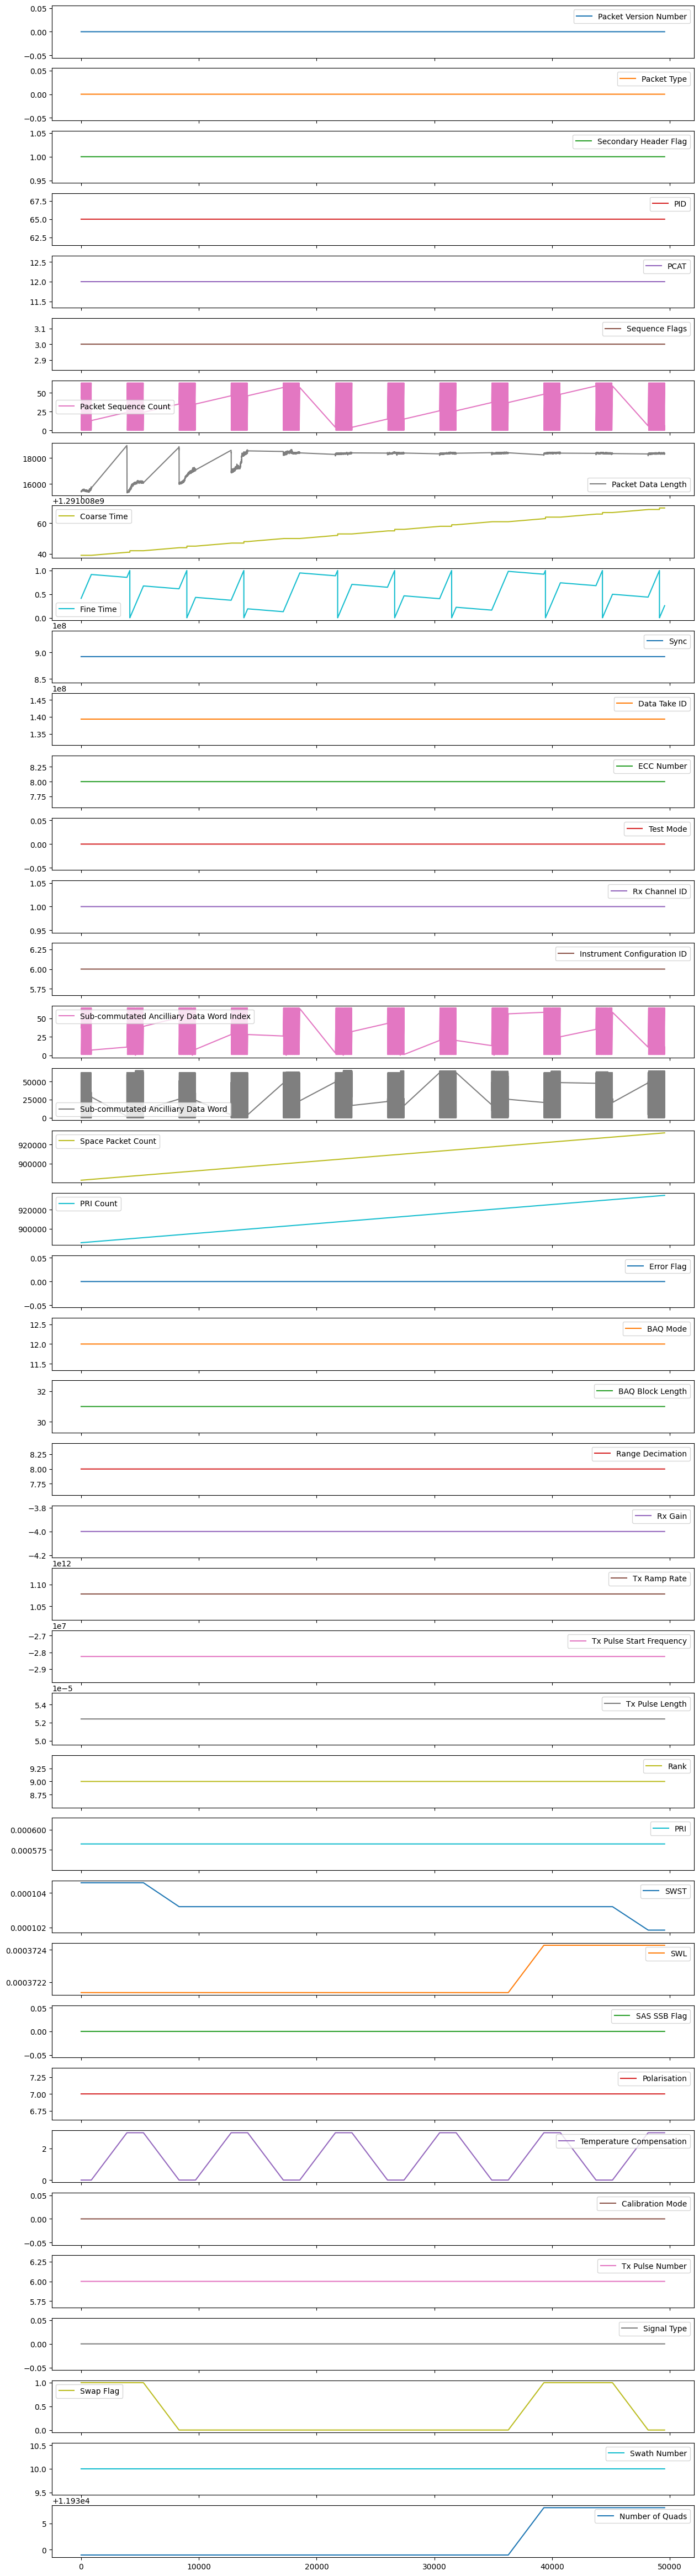

In [14]:
# make a multi-plot of all the columns in the dataframe:
tmp = df
tmp.plot(subplots=True, figsize=(15, 60))
plt.show()

In [17]:
df

,Packet Version Number,Packet Type,Secondary Header Flag,PID,PCAT,Sequence Flags,Packet Sequence Count,Packet Data Length,Coarse Time,Fine Time,...,SWL,SAS SSB Flag,Polarisation,Temperature Compensation,Calibration Mode,Tx Pulse Number,Signal Type,Swap Flag,Swath Number,Number of Quads
0,0,0,1,65,12,3,43,15430,1291008039,0.410454,...,0.000372,0,7,0,0,6,0,1,10,11929
1,0,0,1,65,12,3,44,15442,1291008039,0.411034,...,0.000372,0,7,0,0,6,0,1,10,11929
2,0,0,1,65,12,3,45,15390,1291008039,0.411629,...,0.000372,0,7,0,0,6,0,1,10,11929
3,0,0,1,65,12,3,46,15430,1291008039,0.412209,...,0.000372,0,7,0,0,6,0,1,10,11929
4,0,0,1,65,12,3,47,15410,1291008039,0.412788,...,0.000372,0,7,0,0,6,0,1,10,11929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49559,0,0,1,65,12,3,2,18378,1291008070,0.253502,...,0.000372,0,7,3,0,6,0,0,10,11938
49560,0,0,1,65,12,3,3,18358,1291008070,0.254097,...,0.000372,0,7,3,0,6,0,0,10,11938
49561,0,0,1,65,12,3,4,18378,1291008070,0.254677,...,0.000372,0,7,3,0,6,0,0,10,11938
49562,0,0,1,65,12,3,5,18334,1291008070,0.255257,...,0.000372,0,7,3,0,6,0,0,10,11938


SAS stands for "SAR Auxiliary Subsystem," which is a part of the SAR processing system responsible for auxiliary data management. The auxiliary data are essential for precise SAR image processing and geolocation. SSB is an abbreviation for "Single Sideband," which refers to a technique used in radio communications to reduce the bandwidth required to transmit a signal.

The "SAS SSB Flag" is a metadata attribute included in the Sentinel-1 RAW product files, indicating the status of the single sideband processing applied to the SAR data. The flag can be set to "True" or "False." If it is set to "True," it means the single sideband processing has been applied correctly. If it is set to "False," there may be issues in the SAR data processing or quality, and users should be cautious when using the data for analysis or applications.

Users of Sentinel-1 RAW data can check the metadata of the product files to determine the status of the "SAS SSB Flag" and take necessary actions if the flag indicates potential issues with the data.

In [18]:
try:
    # Locate index where value passes from 1 to 0
    index = df.index[df["SAS SSB Flag"].diff() == -1].tolist()[0]
    print(f"The index where the 'SAS SSB Flag' column passes from 1 to 0 is: {index}")
except:
    index = 0

focuser = RD(decoder=decoder, raw=df.iloc[index:index+1000], ephemeris=ephemeris)
focuser.decode_file()

Raw data shape:  (1000, 23858)


# BAQ

BAQ (Binary Amplitude Quantization) mode is a specific data quantization technique used in Synthetic Aperture Radar (SAR) systems to compress and reduce the amount of data generated during the radar imaging process. SAR systems produce high-resolution images of the Earth's surface by transmitting radar signals and then processing the reflected signals (echoes) from the ground. This process generates a large volume of data, which can be challenging to manage, store, and transmit.

BAQ mode reduces the amount of data by quantizing the amplitude of the received radar echoes. This is achieved by converting the continuous amplitude values of the radar echoes into discrete levels or "bins." Each amplitude value is then represented by a binary code, which requires fewer bits than the original continuous amplitude value.

The main advantage of using BAQ mode in SAR systems is the significant reduction in data size, which simplifies data handling, storage, and transmission. However, quantization can introduce some loss of information, which may affect the image quality to a certain extent. The trade-off between data reduction and image quality depends on the number of quantization levels (or bits) used. More quantization levels result in better image quality but lower data reduction, whereas fewer quantization levels yield higher data reduction but potentially lower image quality.

In summary, BAQ mode is a data quantization technique used in SAR systems to reduce the amount of data generated during the radar imaging process. This technique allows for more manageable data handling, storage, and transmission at the expense of some loss in image quality, depending on the number of quantization levels used.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df["BAQ Mode"].to_list())
plt.xlim([0,1000])
plt.title('BAQ')
plt.show()

# Processing Time:

In [ ]:
# processor = SARLens(decoder, selection, ephemeris)
# processor.decode_file()
# processor.extract_parameters()
# processor.calculate_wavelength()
# processor.calculate_sample_rates()
# processor.create_fast_time_vector()
# processor.calculate_slant_range()
# processor.calculate_axes()
# processor.calculate_spacecraft_velocity()
# processor.calculate_positions()
# processor.calculate_velocity_and_d()
# processor.process_freq_domain_data()
# processor.apply_range_filter()
# processor.apply_rcmc_filter()
# processor.apply_azimuth_filter()
# processor.plot_img()

# # processor.process()

In [ ]:
processor = SARLens(decoder, selection, ephemeris)

In [ ]:
import time

print('Decode File:')
t0 = time.time()
processor.decode_file()
t1 = time.time()
print('Execution time:', t1 - t0)

print('extract_parameters:')
t2 = time.time()
processor.extract_parameters()
t3 = time.time()
print('Execution time:', t3 - t2)

print('calculate_wavelength:')
t4 = time.time()
processor.calculate_wavelength()
t5 = time.time()
print('Execution time:', t5 - t4)

print('calculate_sample_rates:')
t6 = time.time()
processor.calculate_sample_rates()
t7 = time.time()
print('Execution time:', t7 - t6)

print('create_fast_time_vector:')
t8 = time.time()
processor.create_fast_time_vector()
t9 = time.time()
print('Execution time:', t9 - t8)

print('calculate_slant_range:')
t10 = time.time()
processor.calculate_slant_range()
t11 = time.time()
print('Execution time:', t11 - t10)

print('calculate_axes:')
t12 = time.time()
processor.calculate_axes()
t13 = time.time()
print('Execution time:', t13 - t12)

print('calculate_spacecraft_velocity:')
t14 = time.time()
processor.calculate_spacecraft_velocity()
t15 = time.time()
print('Execution time:', t15 - t14)

print('calculate_positions:')
t16 = time.time()
processor.calculate_positions()
t17 = time.time()
print('Execution time:', t17 - t16)

print('calculate_velocity_and_d:')
t18 = time.time()
processor.calculate_velocity_and_d()
t19 = time.time()
print('Execution time:', t19 - t18)

print('process_freq_domain_data:')
t20 = time.time()
processor.process_freq_domain_data()
t21 = time.time()
print('Execution time:', t21 - t20)


In [ ]:
print('apply_range_filter:')
t0 = time.time()
processor.apply_range_filter()
t1 = time.time()
print('Execution time:', t1 - t0)

print('apply_rcmc_filter:')
t2 = time.time()
processor.apply_rcmc_filter()
t3 = time.time()
print('Execution time:', t3 - t2)

# print('apply_azimuth_filter:')
# t4 = time.time()
# processor.apply_azimuth_filter()
# t5 = time.time()
# print('Execution time:', t5 - t4)

# print('plot_img:')
# t6 = time.time()
# processor.plot_img()
# t7 = time.time()
# print('Execution time:', t7 - t6)

In [ ]:
plt.figure(figsize=(5,15))
plt.imshow(abs(processor.range_doppler_data))
plt.axis(False)
plt.show()

In [ ]:
processor.len_az_line


"""Apply the azimuth filter and create the compressed data."""
processor.az_compressed_data = np.zeros((processor.len_az_line, processor.len_range_line), 'complex')

for az_line_index in range(processor.len_range_line):
       try:
              # d_vector = np.zeros(processor.len_az_line)

              this_az_filter = np.zeros(processor.len_az_line, 'complex')
              # for ii in range(len(processor.az_freq_vals) - 1):  # -1
              for ii in range(len(processor.az_freq_vals) - 1):  # -1
                     this_az_filter[ii] = cmath.exp((4j * cmath.pi * processor.slant_range[ii] * processor.D[ii, az_line_index]) / processor.wavelength)
       
       except IndexError:
              print('Error')
              print('len_processor.az_freq_vals:',len(processor.az_freq_vals))
              print('i:',ii)
              print('slant_range.shape:',processor.slant_range.shape)
              print('slant_range.shape:',processor.D.shape)
              print('az_line_index:',az_line_index)

       result = processor.range_doppler_data[:, az_line_index] * this_az_filter[:]
       result = np.fft.ifft(result)
       processor.az_compressed_data[:, az_line_index] = result

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(abs(processor.az_compressed_data), vmin=0, vmax=1000, origin='lower')
plt.show()

In [ ]:
# SOURCE CODE

iq_array = decoder.decode_file(selection)
print("Raw data shape: ", iq_array.shape)
# Image sizes
len_range_line = iq_array.shape[1]
len_az_line = iq_array.shape[0]

# Extract necessary parameters, see both reference documents.
# All necessary parameters are included into the dataframe
c = sentinel1decoder.constants.speed_of_light
TXPL = selection["Tx Pulse Length"].unique()[0]
print("Tx Pulse length", TXPL)
TXPSF = selection["Tx Pulse Start Frequency"].unique()[0]
print("Tx Pulse Start Freq", TXPSF)
TXPRR = selection["Tx Ramp Rate"].unique()[0]
print("Tx Ramp Rate", TXPRR)
RGDEC = selection["Range Decimation"].unique()[0]
print("Range Decimation", RGDEC)
PRI = selection["PRI"].unique()[0]
print("PRI", RGDEC)
rank = selection["Rank"].unique()[0]
print("Rank", rank)
suppressed_data_time = 320/(8*sentinel1decoder.constants.f_ref)  # see pag. 82 of the reference document (Airbus)
print(suppressed_data_time)
range_start_time = selection["SWST"].unique()[0] + suppressed_data_time
wavelength = c / 5.405e9

# Sample rates
range_sample_freq = sentinel1decoder.utilities.range_dec_to_sample_rate(RGDEC)
range_sample_period = 1 / range_sample_freq
az_sample_freq = 1 / PRI
az_sample_period = PRI

# Fast time vector [s] - defines the time axis along the fast time direction
range_line_num = [i for i in range(len_range_line)]
fast_time = [range_start_time + i * range_sample_period for i in range_line_num]


# Slant range vector - defines R0, the range of the closest approach for each range cell (i.e. the slant range when
# the radar is closest to the target)
slant_range = [(rank * PRI + t) * c / 2 for t in fast_time]

# Axes - defines the frequency axes in each direction after FFT
SWL = len_range_line / range_sample_freq
az_freq_vals = np.arange(-az_sample_freq / 2, az_sample_freq / 2, 1 / (PRI * len_az_line))
range_freq_vals = np.arange(-range_sample_freq / 2, range_sample_freq / 2, 1 / SWL)


# We need two parameters which vary over range and azimuth, so we're going to loop over these once
# D is the cosine of the instantaneous squint angle and is defined by the letter D in most literature
# Define a function to calculate D, then apply it inside the loop
def d(range_freq, velocity):
    return math.sqrt(1 - ((wavelength ** 2 * range_freq ** 2) / (4 * velocity ** 2)))


D = np.zeros((len_az_line, len_range_line))

# Spacecraft velocity - numerical calculation of the effective spacecraft velocity
ecef_vels = ephemeris.apply(lambda x: math.sqrt(
    x["X-axis velocity ECEF"] ** 2 + x["Y-axis velocity ECEF"] ** 2 + x["Z-axis velocity ECEF"] ** 2), axis=1)
velocity_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ecef_vels.unique(),
                           fill_value="extrapolate")
x_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ephemeris["X-axis position ECEF"].unique(),
                    fill_value="extrapolate")
y_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ephemeris["Y-axis position ECEF"].unique(),
                    fill_value="extrapolate")
z_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ephemeris["Z-axis position ECEF"].unique(),
                    fill_value="extrapolate")
space_velocities = selection.apply(lambda x: velocity_interp(x["Coarse Time"] + x["Fine Time"]), axis=1)

x_positions = selection.apply(lambda x: x_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()
y_positions = selection.apply(lambda x: y_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()
z_positions = selection.apply(lambda x: z_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()

a = 6378137 # WGS84 semi major axis
b = 6356752.3142 # WGS84 semi minor axis
velocities = np.zeros((len_az_line, len_range_line))

# Now loop over range and azimuth, and calculate spacecraft velocity and D
for i in range(len_az_line):
    H = math.sqrt(x_positions[i]**2 + y_positions[i]**2 + z_positions[i]**2)
    W = float(space_velocities.iloc[i])/H
    lat = math.atan(z_positions[i] / x_positions[i])
    local_earth_rad = math.sqrt(((a**2 * math.cos(lat))**2 + (b**2 * math.sin(lat))**2) / ((a * math.cos(lat))**2 + (b * math.sin(lat))**2))
    for j in range(len_range_line):
        cos_beta = (local_earth_rad**2 + H**2 - slant_range[j]**2) / (2 * local_earth_rad * H)
        this_ground_velocity = local_earth_rad * W * cos_beta
        velocities[i, j] = math.sqrt(float(space_velocities.iloc[i]) * this_ground_velocity)
        D[i, j] = d(az_freq_vals[i], velocities[i, j])

freq_domain_data = np.zeros((len_az_line, len_range_line), dtype=complex)

for az_index in range(len_az_line):
    range_line = iq_array[az_index, :]
    range_fft = np.fft.fft(range_line)
    freq_domain_data[az_index, :] = range_fft

for range_index in range(len_range_line):
    az_line = freq_domain_data[:, range_index]
    az_fft = np.fft.fft(az_line)
    az_fft = np.fft.fftshift(az_fft)
    freq_domain_data[:, range_index] = az_fft

# Create range filter
num_tx_vals = int(TXPL*range_sample_freq)
tx_replica_time_vals = np.linspace(-TXPL/2, TXPL/2, num=num_tx_vals)
phi1 = TXPSF + TXPRR*TXPL/2
phi2 = TXPRR/2
tx_replica = np.zeros(num_tx_vals, dtype=complex)
for i in range(num_tx_vals):
    tx_replica[i] = cmath.exp(2j * cmath.pi * (phi1*tx_replica_time_vals[i] + phi2*tx_replica_time_vals[i]**2))

range_filter = np.zeros(len_range_line, dtype=complex)
index_start = np.ceil((len_range_line-num_tx_vals)/2)-1
index_end = num_tx_vals+np.ceil((len_range_line-num_tx_vals)/2)-2
range_filter[int(index_start):int(index_end+1)] = tx_replica

range_filter = np.fft.fft(range_filter)
range_filter = np.conjugate(range_filter)

for az_index in range(len_az_line):
    freq_domain_data[az_index, :] = freq_domain_data[az_index, :]*range_filter


rcmc_filt = np.zeros(len_range_line, dtype=complex)
range_freq_vals = np.linspace(-range_sample_freq/2, range_sample_freq/2, num=len_range_line)
for az_index in range(len_az_line):
    rcmc_filt = np.zeros(len_range_line, dtype=complex)
    for range_index in range(len_range_line):
        rcmc_shift = slant_range[0]*((1/D[az_index, range_index])-1)
        rcmc_filt[range_index] = cmath.exp(4j * cmath.pi * range_freq_vals[range_index] * rcmc_shift / c)
    freq_domain_data[az_index, :] = freq_domain_data[az_index, :]*rcmc_filt

range_doppler_data = np.zeros((len_az_line, len_range_line), dtype=complex)
for range_line_index in range(len_az_line):
    ifft = np.fft.ifft(freq_domain_data[range_line_index, :])
    ifft_sorted = np.fft.ifftshift(ifft)
    range_doppler_data[range_line_index, :] = ifft_sorted



In [ ]:
# Create azimuth filter
az_compressed_data = np.zeros((len_az_line, len_range_line), 'complex')

for az_line_index in range(len_range_line):
    d_vector = np.zeros(len_az_line)
    this_az_filter = np.zeros(len_az_line, 'complex')
    print('Azimuth_Filter_shape:',this_az_filter.shape)
    print(len(slant_range))
    print(D.shape)
    print(az_freq_vals.shape)
    print('Azimuth Freq Vals:',len(az_freq_vals)-1)
    for i in range(len(az_freq_vals)-1):  # -1
        this_az_filter[i] = cmath.exp((4j * cmath.pi * slant_range[i] * D[i, az_line_index]) / wavelength)
    result = range_doppler_data[:, az_line_index] * this_az_filter[:]
    result = np.fft.ifft(result)
    az_compressed_data[:, az_line_index] = result

# Plot final image
plt.figure(figsize=(16,100))
plt.title("Sentinel-1 Processed SAR Image")
plt.imshow(abs(az_compressed_data[:,:]), vmin=0, vmax=2000, origin='lower')
plt.xlabel("Down Range (samples)")
plt.ylabel("Cross Range (samples)")
plt.show()